### Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fftpack import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Util Functions

In [2]:
sampleRate = 20e6

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

def getData(cfileName):
    """
    Given a name of a *.cfile, this function extracts the interleaved
    Inphase-Quadrature data samples and convert it into a numpy array of complex
    data elements. *.cfile format has interleaved I and Q samples where each sample
    is a float32 type. GNURadio Companion (GRC) scripts output data into a file
    though a file sink block in this format.
    Read more in SDR data types: https://github.com/miek/inspectrum
    """
    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")
    
    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    # print("data type=", type(data))
    # Return the complex numpy array.
    return data

def getSegmentData(iqData, offsetTime, windowTime):
    '''
    Given a I-Q data, an offset value as a time, and an window time,
    this function extracts the required segment from the data and return it as
    a complx numpy array.    
    '''

    # Segment starting offset (sample points)
    start = offsetTime * sampleRate    
    # Segment ending offset (sample points)
    end = start + (windowTime * sampleRate)
    #print("start=%d", int(start))
    #print("end=%d", int(end))
    #Return the starting index and ending index
    segment = iqData[int(start):int(end)]

    #return data
    return segment

def getTimeDuration(complexData):
    '''
    Calculate the total time duration represented in complex Numpy array.
    '''
    # each complex value represents a sample
    nSamples = len(complexData)

    # nSamples = duration x sample_rate
    duration =  nSamples / sampleRate
    return duration

def getFilePath(type, payload, freq):
    if type == "udp":
        if payload == 1:
            flag = "udp_all_1"
        else:
            flag = "udp_all_0"
    else:
        if payload == 1:
            flag = "tcp_all_1"
        else:
            flag = "tcp_all_0"

    filePath = f"../dataset/10s20MHz/{flag}_freq={freq}.0em_capture.cfile"
    return filePath

def loadData(type, payload, freq):
    filePath = getFilePath(type, payload, freq)
    dataSet = getData(filePath)
    print(f"Loaded {type} all {payload}, {freq}.0MHz")

    return dataSet

def loadSegment(type, payload, freq, offset, length):
    filePath = getFilePath(type, payload, freq)
    
    dataSet = getData(filePath)
    dataSegment = getSegmentData(dataSet, offset, length)
    print(f"Loaded {type} all {payload}, {freq}.0MHz of {length}s length starting from {offset}s")
    
    return dataSegment

def plotWaveform(data, show=1, file_name='./wavform.pdf', file_format='pdf'):
    """
    Given a data set as a complex numpy array, this function returns the waveform plot.
    """
    plt.figure()
    # Plot the waveform of the selected sample range of the numpy data array
    #plt.plot(data)
    plt.plot(np.abs(data))
    #plt.plot(np.real(data))
    #plt.plot(np.imag(data))
    
    if(show==1):
        plt.show()
    else:
        # Save the waveform into a PDF file
        plt.savefig(file_name, fotmat=file_format, bbox_inches='tight')
        
    return 1

def plotFFT(data, show=1):
    """
    Given a data set as a complex numpy array, this function returns the FFT plot.
    """

    plt.figure()

    # get the length of the selected data sample range        
    N = len(data)
    # get the time interval beteween each sample
    T = 1.0 / sampleRate
    # calculate the FFT of the selected sample range. But the FFT x axis contains data
    # in the range from 0 to positive values first and at the end the negative values
    # like 0, 1, 2, 3, 4, -4, -3, -2, -1
    yf = fft(data)
    # get the vector with frequencies of the sample range. But the output contains data
    # in the range from 0 to positive values first and at the end the negative values
    # like 0, 1, 2, 3, 4, -4, -3, -2, -1
    freqs = fftfreq(N, T)
    # shift the frequencies to have it zero-centered, e.g., -4, -3, -2, -1, 0, 1, 2, 3, 4
    shifted_freqs = fftshift(freqs)
    # rearrange the FFT vector to have it zero-centered, e.g., -4, -3, -2, -1, 0, 1, 2, 3, 4
    new_yf = np.concatenate((yf[int(N/2):int(N)], yf[0:int(N/2)]))
    # plot the FFT vector against the frequencies
    plt.plot(shifted_freqs, np.abs(new_yf))    
    #print('len(shifted_freqs)=%d' % len(shifted_freqs))    
    #print('len(new_yf)=%d' % len(new_yf))    

    if(show==1):
        plt.show()
    else:
        # save theFFT plot as a PDF file.
        plt.savefig('./fft.pdf', fotmat='pdf', bbox_inches='tight')
        
    return 1

def getFFT(pattern):
    _, _, fft_result = signal.stft(pattern, fs=sampleRate, nperseg=fft_size, noverlap=fft_overlap)
    return fft_result

def computeNormalizedXcor(signalI, signalJ):
    normalizedI = (signalI - np.mean(signalI)) / (np.std(signalI))
    normalizedJ = (signalJ - np.mean(signalJ)) / (np.std(signalJ))
    c = signal.correlate(normalizedI, normalizedJ, mode="full") / max(len(signalI), len(signalJ))
    print("XCOR", c)
    center = int(len(c)/2)
    return (c[center], center, c)


def computeXcor(signalI, signalJ):
    c = signal.correlate(signalI, signalJ, mode="full") / max(len(signalI), len(signalJ))
    center = int(len(c)/2)
    return (c[center], center, c)

#### Loading and resampling

In [3]:
offset = 2 #seconds
duration = 1e-1 #seconds

data1_segment = loadSegment("tcp", 1, 70, offset, duration)
data2_segment = loadSegment("tcp", 0, 70, offset, duration)

resampleRate = 10e6
resampled1 = signal.resample(data1_segment, num=int(resampleRate * duration), t=None, axis=0, window=None, domain='time')
resampled2 = signal.resample(data2_segment, num=int(resampleRate * duration), t=None, axis=0, window=None, domain='time')


Loaded tcp all 1, 70.0MHz of 0.1s length starting from 2s
Loaded tcp all 0, 70.0MHz of 0.1s length starting from 2s


XCOR [-7.86687970e-07 -2.43264008e-06 -1.08684802e-06 ... -1.08716798e-06
 -2.43299198e-06 -7.86176026e-07]
Value 0.999999875
Value2 0.0006831358032226562


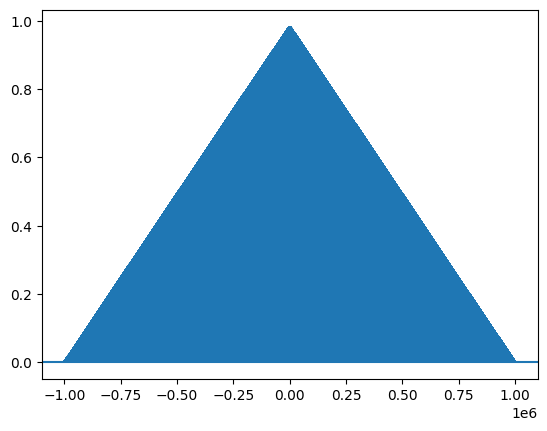

In [4]:
resampled1 = abs(resampled1)
resampled2 = abs(resampled2)

corr = plt.xcorr(resampled1, resampled2, maxlags=None, normed=True)
print("Value", computeNormalizedXcor(resampled1, resampled1)[0])

print("Value2", computeXcor(resampled1, resampled2)[0])

In [8]:
# data1, filePath1 = loadData("tcp", 1, 30)
# duration1 = getTimeDuration(filePath1)
# print("Time duration of the cf ile file: " + str(duration1) + " seconds")

# data2, filePath2 = loadData("tcp", 0, 110)
# duration2 = getTimeDuration(filePath2) 
# print("Time duration of the cfile file: " + str(duration2) + " seconds")

# length = len(data1)
# print("Number of samples in cfile data segment: " + str(length))

sampleRate = 20e6
offset = 2 #seconds
duration = 1e-1 #seconds
freqs = [e for e in range(30,111,20)]
nFreqs = len(freqs)

# Initialize a list to store cross-correlation results
cross_correlation_results = []

# for i in range(nFreqs):
#     for j in range(i+1,nFreqs):
#         print(freqs[i],freqs[j])
#         data1_segment = loadSegment("tcp", 1, freqs[i], offset, duration)
#         data2_segment = loadSegment("tcp", 1, freqs[j], offset, duration)

#         resampleRate = 10e6
#         resampled1 = signal.resample(data1_segment, num=int(resampleRate * duration), t=None, axis=0, window=None, domain='time')
#         resampled2 = signal.resample(data2_segment, num=int(resampleRate * duration), t=None, axis=0, window=None, domain='time')

#         corr = plt.xcorr(abs(resampled1), abs(resampled2), maxlags=None, normed=True)

#         corr_values = corr[1]
#         print(corr_values[np.argmax(corr_values)])
#         cross_correlation_results.append(corr_values[np.argmax(corr_values)])
        
data1_segment = loadSegment("tcp", 1, 50, offset, duration)
resampleRate = 10e6
resampled1 = signal.resample(data1_segment, num=int(resampleRate * duration), t=None, axis=0, window=None, domain='time')
getFFT(abs(data1_segment))

def getCosineSimilarity(fft_ti, fft_tj):
    return 1 - cosine(fft_ti.flatten(), fft_tj.flatten())

cosine_similarity = getCosineSimilarity(fftI, fftJ)

print("Cosine Similarity:", cosine_similarity)

# length1 = len(data1_segment)
# print("Number of samples in cfile data segment: " + str(length1))
# print("Duration1: ", getTimeDuration(data1_segment))
# length2 = len(data2_segment)
# print("Number of samples in cfile data segment: " + str(length2))
# print("Duration2: ", getTimeDuration(data2_segment))

Loaded tcp all 1, 50.0MHz of 0.1s length starting from 2s


array([[ 1.3602816e-02+0.00000000e+00j,  2.7279407e-02+0.00000000e+00j,
         2.7346905e-02+0.00000000e+00j, ...,
         2.7281947e-02+0.00000000e+00j,  1.6547674e-02+0.00000000e+00j,
         0.0000000e+00+0.00000000e+00j],
       [-6.7949798e-03+8.67433287e-03j, -1.3751213e-02-1.03888116e-04j,
        -1.3698394e-02+4.45691476e-05j, ...,
        -1.3619113e-02-1.87707788e-04j, -9.8130004e-03-7.75561063e-03j,
         0.0000000e+00+0.00000000e+00j],
       [-5.7974750e-05-5.76792471e-03j,  9.6007883e-05+1.21573488e-04j,
         3.4145898e-05+1.97893351e-05j, ...,
        -1.7617887e-05+1.31921886e-04j,  2.9507307e-03+4.28707851e-03j,
         0.0000000e+00+0.00000000e+00j],
       ...,
       [ 3.4097062e-05-2.20955393e-04j,  6.6245579e-05-9.40937098e-05j,
         9.5215342e-05-1.35852097e-04j, ...,
        -5.2980835e-05+8.77966813e-05j,  3.7572513e-04-4.79552895e-04j,
         0.0000000e+00+0.00000000e+00j],
       [ 2.3827283e-04+3.37191508e-04j,  4.7304481e-04+1.09972825e-0

In [ ]:
# print(len(data1_segment))
resampleRate = 10e6
resampled1 = signal.resample(data1_segment, num=int(resampleRate * duration), t=None, axis=0, window=None, domain='time')
resampled2 = signal.resample(data2_segment, num=int(resampleRate * duration), t=None, axis=0, window=None, domain='time')

# print(len(resampled1))
sampleRate = resampleRate
# print("Duration1: ", getTimeDuration(resampled1))

corr = plt.xcorr(abs(resampled1), abs(resampled2), maxlags=None, normed=True)

# corr_values = corr[1]
# print(corr_values[np.argmax(corr_values)])

In [27]:
corr_values = corr[1]
print(corr_values[np.argmax(corr_values)])

0.94316804


In [36]:
freqs = [e for e in range(30,111,20)]
nFreqs = len(freqs)

# Initialize a list to store cross-correlation results
cross_correlation_results = []
print(freqs)
for i in range(nFreqs):
    for j in range(i+1,nFreqs):
        print(freqs[i],freqs[j])
        
    

[30, 50, 70, 90, 110]
30 50
30 70
30 90
30 110
50 70
50 90
50 110
70 90
70 110
90 110


### Util Functions 2

In [ ]:


trimLength = (196031181+197657076)//3
print("trim lenght", trimLength)
def getMinLength(pattern_i, pattern_j):
    minLen = min(len(pattern_i), len(pattern_j), trimLength)
    print(f"minimum length of datasets: {minLen}")
    return minLen



In [ ]:
# freqs = [e for e in range(30,211,20)]
# print(freqs)


# dataLengths = []


# for freq in freqs:
#     data = loadData("tcp", 1, freq)
#     dataLengths.append(len(data))

# for freq in freqs:
#     data = loadData("tcp", 0, freq)
#     dataLengths.append(len(data))

# for freq in freqs:
#     data = loadData("udp", 1, freq)
#     dataLengths.append(len(data))

# for freq in freqs:
#     data = loadData("udp", 0, freq)
#     dataLengths.append(len(data))

# print(min(dataLengths))
# print(max(dataLengths))


### Loading datasets for trials

In [ ]:
freqs = [e for e in range(30,111,20)]
nFreqs = len(freqs)

# Initialize a list to store cross-correlation results
cross_correlation_results = []

# Loop over all pairs of datasets
dataSetI = loadData("tcp", 1, 30)
dataSetJ = loadData("udp", 1, 110)

# Ensure datasets have the same length by truncating the longer dataset
# min_length = getMinLength(dataSetI, dataSetJ)

# dataSetI = dataSetI[:min_length]
# dataSetJ = dataSetJ[:min_length]

In [ ]:
new_data = signal.resample(dataSetI, num=10e6, t=None, axis=0, window=None, domain='time')
print(len(new_data))

### Using plt.xcorr()

In [ ]:
# Compute cross-correlation between the datasets
corr = plt.xcorr(dataSetI, dataSetJ, maxlags=None, normed=True)

corr_values = corr[1]
print(corr_values[np.argmax(corr_values)])

### Using np.correlate()

In [ ]:
# Compute cross-correlation between the datasets
cross_corr = np.correlate(dataSetI, dataSetJ, mode='full')
lags = np.arange(-len(cross_corr) + 1, len(cross_corr))

# Plot the cross-correlation data
plt.plot(lags, cross_corr)
plt.title('Cross-correlation Plot')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.show()


#### Finding length of dataSets

In [ ]:
freqs = [e for e in range(30,111,20)]
nFreqs = len(freqs)

# Initialize a list to store cross-correlation results
cross_correlation_results = []
min_length = 0
max_length = 0
# Loop over all pairs of datasets
for i in range(nFreqs):
    dataSetI = loadData("tcp", 0, freqs[i])
    max_length = max(len(dataSetI), len(dataSetJ), max_length)
    print(max_length)
    
print(max_length)

### Pearson Correlation

In [ ]:
fftI = getFFT(dataSetI)
print(fftI.shape)
fftJ = getFFT(dataSetJ)
print(fftJ.shape)

def getCosineSimilarity(fft_ti, fft_tj):
    return 1 - cosine(fft_ti.flatten(), fft_tj.flatten())

cosine_similarity = getCosineSimilarity(fftI, fftJ)

print("Cosine Similarity:", cosine_similarity)
